# 利用Iterative Deepening DFS (疊代深度優先演算法)尋找蜜蜂收集花蜜的最佳路近


## 1.首先了解什麼是【DFS、DLS】

Depth-first Search(DFS)，中文名稱叫做深度優先搜索法。從起始點開始往下搜索，先選定一個未搜尋的節點，盡可能地搜索下去，直到該節點延伸下去的路都已搜索。就回朔到前一個節點重複繼續搜索。
而缺點就是會無法找到最佳解，因此我們可以限制最大搜索深度，則稱之為Depth-limited Search(DLS)，但還是有可能無法找到最佳解。所以我才使用 terative Deepening DFS(IDS)，為改良版的DLS，逐次的放寬深度限制，直到找到目標為止。和(廣度優先演算法)有同樣的時間複雜度，且空間複雜度優於廣度優先演算法。

## 2.遊戲規則 (蜜蜂找花蜜)

a.下圖是我們的棋盤

                                                x x x x x x x x 
                                                x b x x x x x x 
                                                x . . x . x x x 
                                                x . . x . x . x 
                                                x . x . x 1 . x 
                                                x x x . . . . x 
                                                x . x . x . x x 
                                                x x x h . x x x 
                                                x x x x 1 . . x 
                                                x x x x x x . x 
                                                x x x x x x x x 
b.符號代表

      x :代表牆壁，蜜蜂不能行走的地方

      . :代表路，蜜蜂可以行走的地方

      h :代表花蜜，蜜蜂必須收集的東西，以蒐集全部為目標

      1 :為捷徑，可以傳送到相對數字的地方

C. 操作方式

        由於單一路長的是六角形(如下圖)，為了簡化棋盤樣式，則自行定義蜜蜂行走的路徑。藍色為同一列，紅色為同一行
        
  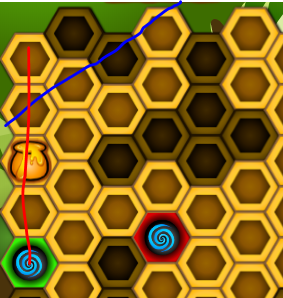

        實際蜜蜂走法    程式執行

            上          上

            下          下      

            右上        右

            右下        右下

            左上        左上

            左下        左

# 程式碼撰寫

In [90]:
import numpy as np
from enum import Enum
import copy
import time

## 1.設定Enum來方便觀看程式的可見性

In [91]:
class NOROAD(Enum):
    #No代表死路，FINISH代表花蜜全部找完
    NO=0
    FINISH=1
    
class Direction(Enum):
    UP = 0
    DOWN = 1
    RIGHT_UP = 2
    LEFT_UP = 3
    RIGHT_DOWN = 4
    LEFT_DOWN = 5
    
class PointType(Enum):
    ROAD = 0
    WALL = 1
    HYPERLINK = 2

## 2.設定物件的屬性

#### 1.Location:為父類別存取row和colum，並且包含判斷兩點row或colum是否想等的__eq__和__ne__。getDirection用來移動蜜蜂用的函式。
#### 2.Road、Honey、Wall:分別繼承Location，並且設定Type的屬性
#### 3.Bee: 同樣也繼承Location，setLocation為設定起始點
#### 4.Hyperlink:繼承Location，同時也設定相對應的捷徑的位置
#### 5.Hive: 讀取以解讀的txt檔，並呼叫各個物件，並且做一寫之後會使用的涵式。

In [92]:
class Location(object):
    def __init__(self,row,col):
        self.row=row
        self.col=col        
    def __eq__(self, other):
        return self.row == other.row and self.col == other.col
    def __ne__(self, other):
        return self.row != other.row or self.col != other.col     
    def getDirection(self,direct):
        loc=Location(self.row,self.col)
        if direct==Direction.UP:
            loc.row-=1
        elif direct==Direction.DOWN:
            loc.row+=1
        elif direct==Direction.RIGHT_UP:
            loc.col+=1
        elif direct==Direction.RIGHT_DOWN:
            loc.col+=1
            loc.row+=1
        elif direct==Direction.LEFT_UP:
            loc.col-=1
            loc.row-=1
        elif direct==Direction.LEFT_DOWN:
            loc.col-=1
        return loc
    
class Road(Location):
    def __init__(self, row, col):
        super().__init__(row, col)
        self.type=PointType.ROAD
    def __str__(self):
        return ". "

class Honey(Location):
    def __init__(self, row, col):
        super().__init__(row, col)
        self.type=PointType.ROAD
    def __str__(self):
        return "h "
    
class Wall(Location):
    def __init__(self, row, col):
        super().__init__(row, col)
        self.type=PointType.WALL
    def __str__(self):
        return "x "
    
class Hyperlink(Location):
    def __init__(self, row, col, tid):
        super().__init__(row, col)
        self.hys=Location(-1, -1)
        self.id=int(tid)
        self.type=PointType.HYPERLINK
    def getHys(self):
        return self.hys
    def setHys(self, row, col): #設定Hyperlink的傳送點
        self.hys.row=row
        self.hys.col=col
    def __str__(self):
        return str(self.id)+" "

class Bee(Location):
    def __init__(self, row, col):
        super().__init__(row, col)
        self.type=PointType.ROAD
    def setLocation(self, row, col):
        self.loc=Location(row, col)        
    def __str__(self):
        return "b "
    
class Hive(object):
    def __init__(self,Graph,size):
        self.gRow=size[0]
        self.gCol=size[1]
        self.bee=Bee(0,0) #設定蜜蜂的初始值
        self.honey=[] #存取蜂蜜的位置
        hyperlink=[] #存取捷徑的號碼
        self.graph=[] #存取各個物件的陣列
        for i in range (self.gRow):
            self.graph.append([])
            for j in range (self.gCol):
                if Graph[i][j]=='x':
                    self.graph[i].append(Wall(i,j)) #生成Wall
                elif Graph[i][j]=='.':
                    self.graph[i].append(Road(i,j)) #生成Road
                elif Graph[i][j]=='b':
                    self.bee.setLocation(i,j) #設定bee屬性的位置
                    self.graph[i].append(Bee(i,j)) #生成Bee
                elif Graph[i][j]=='h':
                    self.graph[i].append(Honey(i,j))  #生成Honey
                    self.honey.append(Honey(i,j))  #把Honey存進honey
                else:
                    self.graph[i].append(Hyperlink(i,j,Graph[i][j]))
                    flag=False
                    for k in range(len(hyperlink)):  
                         if hyperlink[k]['id']==Graph[i][j]:  #在hyperlink判斷id是否正確
                            self.graph[i][j].setHys(hyperlink[k]['row'],hyperlink[k]['col']) #設定各自Hyperlink的傳送點
                            self.graph[hyperlink[k]['row']][hyperlink[k]['col']].setHys(i,j)
                            del hyperlink[k]
                            flag=True
                            break
                    if not flag:
                        hyperlink.append({'id':Graph[i][j],'row':i,'col':j})   #把Hyperlink存進hyperlink做成Library
    def __str__(self): #列印graph陣列
        string=""
        for i in range(self.gRow):
             for j in range(self.gCol):
                    string+=str(self.graph[i][j])
             string+="\n"   
        return string
    def getgraph(self,start): #取得graph裡的物件
        return self.graph[start.row][start.col]
    
    def HoneyCheck(self,start): #確認honey裡的Honey位置是否相同
        for honey in self.honey:
            if honey.row == start.row and honey.col==start.col:
                return True
        return False
    
    def TakeHoney(self,start): #如果相同，把honey裡的Honey刪除
        for honey in self.honey:
            if honey.row == start.row and honey.col==start.col:
                self.honey.remove(honey)
                
    def getHyperLink(self,start): #如果此點的Type為HYPERLINK，則取得傳送點並傳送
        if self.graph[start.row][start.col].type==PointType.HYPERLINK:
            return self.graph[start.row][start.col].getHys()
        return start

## 3.讀取檔案，並且存成陣列，回傳(陣列)以及(大小)

In [93]:
def readFile(filename):
    f=open(filename,'r')
    elements=[]
    for line in f:
        line=line.split()
        elements.append(line)
    ele_array = np.array(elements)
    return ele_array, ele_array.shape

## 4. 執行Search_IDS，並且使用time紀錄時間

In [94]:
def Search_IDS(hive,maxDepth):
    StartTime=time.time()
    route,cost=IDS(hive,maxDepth) #回傳路徑的陣列以及花的步數
    EndTime=time.time()
    print('time=', EndTime-StartTime, 'sec')
    print('cost: ',cost)
    string=[]
    for i in range(len(route)-1,0,-1): #利用for迴圈把路徑一個個列印出來
        
        if route[i]==Direction.UP:
            string.append('↑')
        elif route[i]==Direction.DOWN:
            string.append('↓')
        elif route[i]==Direction.RIGHT_UP:
            string.append('↗')
        elif route[i]==Direction.RIGHT_DOWN:
            string.append('↘')
        elif route[i]==Direction.LEFT_UP:
            string.append('↖')
        elif route[i]==Direction.LEFT_DOWN:
            string.append('↙')
    
    print(string)

In [95]:
def IDS(hive,maxDepth):
    start=hive.bee.loc #呼叫hive裡的bee屬性的位置
    for lteration in range (maxDepth): #限制深度並開始疊代
        pathlist=[]
        costlist=[]   
        for direct in list(Direction): #把六個方位都跑一次
            Nhive=copy.deepcopy(hive)
            path,cost=DLS(Nhive,initWalk(hive,hive.bee.loc),start.getDirection(direct),lteration) 
            costlist.append(cost) #每回傳一次就紀錄步數以及路徑(值)
            pathlist.append(path)
        Direction_index,way = Mincost(costlist) #尋找最小的路徑(值)
        path =pathlist[Direction_index]  #path陣列存取最小路徑
        path.append(Direction(Direction_index)) 
        if path[0]==NOROAD.FINISH: #假如第一個元素為FINISH則回傳陣列及cost
            return path, way+1
    print('NO found')    
    return path, way+1

In [96]:
def DLS(Nhive,walk,start,lteration):
    if lteration<=0: #如果限制小於0，回傳極大值
        return [NOROAD.NO],int(infinite)
    start=Nhive.getHyperLink(start) #呼叫捷徑的函式
    if Nhive.getgraph(start).type==PointType.WALL or walk[start.row][start.col]!=0: #如果此點的type為WALL或著已走過的路，則回傳極大值
        return [NOROAD.NO],int(infinite)
    walk[start.row][start.col]=1 #標註走過的路
    if Nhive.HoneyCheck(start): #確認是否為蜂蜜
        Nhive.TakeHoney(start)   #取蜂蜜
        if len(Nhive.honey)>0: #如果蜂蜜未取完，重製棋盤
            walk=initWalk(Nhive,start)
        else:
            return [NOROAD.FINISH],0 #取完則回傳0值
     
    #假設可以繼續走，則紀錄棋盤，繼續互叫自己(遞迴)的方式直到找完蜂蜜或死路
    new_walk=copy.deepcopy(walk)
    Costlist=[]
    Pathlist=[]
    for direct in list(Direction):
        N_hive=copy.deepcopy(Nhive)
        Path,Cost=DLS(N_hive,new_walk,start.getDirection(direct),lteration-1)
        Costlist.append(Cost)
        Pathlist.append(Path)
    Direction_index,way=Mincost(Costlist)
    path =Pathlist[Direction_index]
    path.append(Direction(Direction_index))
    return path, way+1

In [97]:
def initWalk(hive,start):
    # 0代表位走過 ， 1代表走過
    unwalked=[]
    for i in range(hive.gRow):
        unwalked.append([])
        for j in range(hive.gCol):
            unwalked[i].append(0)  
    unwalked[start.row][start.col]=1 #紀錄蜜蜂的點為走過的路
    return unwalked  

def Mincost(costlist): #尋找最小值，回傳引數和值
    min_index=np.argmin(np.asarray(costlist))
    return min_index,costlist[min_index]

In [98]:
global infinite
infinite=1e10
maxDepth=50
file,size=readFile('input.txt') #呼叫檔案並轉成陣列
hive=Hive(file,size) #生成Hive物件
print(hive) #印出棋盤
Search_IDS(hive,maxDepth) #進入IDS演算法

x x x x x x x x 
x b x x x x x x 
x . . x . x x x 
x . . x . h . x 
x . x . x 1 . x 
x x x . . . . x 
x . x . x . . x 
x x x h . x x x 
x x x x 1 . . x 
x x x x x x . x 
x x x x x x x x 

time= 3.3740413188934326 sec
cost:  8
['↓', '↘', '↘', '↓', '↓', '↓', '↘', '↑']


## 5. 結論

#### IDS算是一個解決了是否找到理想值，以及節省空間複雜度的演算法。實際應用可以更了解到此演算法的優點以及理論意義